# XGBoost Extended Best Model Framewise prediction on Different Simulation
> Created Feb. 2025 <br>
> Nikhil Bisht<br>

In [21]:
# standard system modules
import os, sys
os.environ["PATH"] += os.pathsep + "/home/nbisht/myapps/bin/"
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
import xgboost as xgb

import sklearn.metrics as skm

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE_1  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET_1 = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
DATAFILE_2  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/u503_ML_dataset_AllData_AutoEnc.h5'
CORESET_2 = '/data/cb1/Projects/P19_CoreSimulations/CoreSets/u500/u503_all_frame_all_prim.h5'
DATAFILE_3  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/u502_ML_dataset_AllData_AutoEnc.h5'
CORESET_3  = '/data/cb1/Projects/P19_CoreSimulations/CoreSets/u500/u502_all_frame_all_prim.h5'

MODELFILE = 'nnmodel.json'

ALL_COLUMNS = ['Particle_id', 'Initial_Frame', 'X_i', 'Y_i', 'Z_i', 'Vx_i', 'Vy_i', 'Vz_i', 'Density_i', 'X_f', 'Y_f', 'Z_f', 'Density_f']
FEATURES = ALL_COLUMNS[1:9]
TARGET_lvl1 = ALL_COLUMNS[9:12]
TARGET_lvl2 = ALL_COLUMNS[12]
TARGET = TARGET_lvl1+[TARGET_lvl2]

TRAIN_FRAMES = np.arange(20,75)
TEST_FRAMES = np.arange(20,75,10)
FRAME_DIFF = 30

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')



Available device: cpu 


### Functions

In [36]:
def plot_prediction(y_true,y_pred, mae, r2, append=''):
    fig = plt.figure(figsize=(15, 4))
    for i in range(4):
        ax = plt.subplot(1, 4, i+1)
        ax.scatter(y_true[:,i], y_pred[:,i], c='crimson', s=1e-2)
        ax.plot([0, 0], [1, 1], 'b-')
        ax.set_xlabel('True Values', fontsize=15)
        ax.set_ylabel('Predictions', fontsize=15)
        ax.set_title(f'{TARGET[i]}: MAE = {mae[i]:.6f}, R2 = {r2[i]:.4f}', fontsize=12)
        ax.set_ylabel(TARGET[i])
        #ax.set_xlim([-0.1,1.1])
        #ax.set_ylim([-0.1,1.1])
    fig.tight_layout()
    plt.savefig('Particles_u502_Prediction'+append+'.png')
    plt.show()

def df_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['del_X'] = df['X_f'] - df['X_i']
    df['del_Y'] = df['Y_f'] - df['Y_i']
    df['del_Z'] = df['Z_f'] - df['Z_i']
    df['X_op'] = np.where(np.abs(df['X_i'])<distance_condition, -1, +1)
    df['Y_op'] = np.where(np.abs(df['Y_i'])<distance_condition, -1, +1)
    df['Z_op'] = np.where(np.abs(df['Z_i'])<distance_condition, -1, +1)
    df['X_f'] = np.where(np.abs(df['del_X'])<distance_condition, df['X_f'], df['X_f']+df['X_op'])
    df['Y_f'] = np.where(np.abs(df['del_Y'])<distance_condition, df['Y_f'], df['Y_f']+df['Y_op'])
    df['Z_f'] = np.where(np.abs(df['del_Z'])<distance_condition, df['Z_f'], df['Z_f']+df['Z_op'])
    return df

def df_inverse_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['X_f'] = np.where(df['X_f']>=1, df['X_f']-1, df['X_f'])
    df['X_f'] = np.where(df['X_f']<0, df['X_f']+1, df['X_f'])
    df['Y_f'] = np.where(df['Y_f']>=1, df['Y_f']-1, df['Y_f'])
    df['Y_f'] = np.where(df['Y_f']<0, df['Y_f']+1, df['Y_f'])
    df['Z_f'] = np.where(df['Z_f']>=1, df['Z_f']-1, df['Z_f'])
    df['Z_f'] = np.where(df['Z_f']<0, df['Z_f']+1, df['Z_f'])
    return df

def get_lvl1_dataset(X,y):
    df = y.copy()
    frame_col = X_test['Initial_Frame']+FRAME_DIFF
    df.insert(3, 'Frame', frame_col.values)
    return df

def model_test(model, test_df, distance_condition = 0.5):
    y_pred = model.predict(test_df[FEATURES])
    y_pred_df = pd.DataFrame({'X_f': y_pred[:, 0], 'Y_f': y_pred[:, 1], 'Z_f': y_pred[:, 2]})
    y_pred_df =  df_inverse_transform(y_pred_df, distance_condition = distance_condition)
    
    return y_pred_df

def mae_modded(y_true, y_pred):
    mae = np.array([0.,0.,0.])
    mae_diff = np.abs(y_true - y_pred)
    mae_add = 1 - mae_diff
    stacked = np.stack([mae_diff, mae_add], axis=2)
    mae = stacked.min(axis=2).mean(axis=0)
    return mae

def r2_modded(y_true, y_pred):
    true_mean = np.mean(y_true,axis=0)
    mae_diff = np.abs(y_true - y_pred)
    mae_add = 1 - mae_diff
    stacked = np.stack([mae_diff, mae_add], axis=2)
    r2_residual = stacked.min(axis=2)**2
    mae_diff = np.abs(y_true - true_mean)
    mae_add = 1 - mae_diff
    stacked = np.stack([mae_diff, mae_add], axis=2)
    r2_total = stacked.min(axis=2)**2

    return 1-r2_residual.sum(axis=0)/r2_total.sum(axis=0)

## Load data

In [13]:
def get_timeseries_df(datafile, coreset, frames, frame_diff, concat_df = False):
    df_core_pids =[]
    with h5py.File(coreset, 'r') as f:
        tm = f['track_manager']
        df_core_pids = tm['particle_ids'][()]
        
    #get data and prepare sample
    df_timeseries_core = pd.DataFrame([], columns=ALL_COLUMNS)
    df_timeseries_noncore = pd.DataFrame([], columns=ALL_COLUMNS)
    f =  h5py.File(datafile, 'r')
    for frame_num_index in range(len(frames)):
        frame_num = frames[frame_num_index]
        print(frame_num , end = ' ')
        temp_df_timeseries = pd.DataFrame([], columns=FEATURES)
        temp_final_df = pd.DataFrame([], columns=['Particle_id'])
        f_frame_ini = f[str(frame_num)]
        f_frame_fin = f[str(frame_num+frame_diff)]
        temp_df_timeseries['Initial_Frame'] = np.repeat(frame_num, len(f_frame_ini['Particle_id'][()]))
        temp_df_timeseries['Particle_id'] = f_frame_ini['Particle_id'][()]
        temp_df_timeseries['Particle_id'] = temp_df_timeseries['Particle_id'].astype('int32')
        temp_df_timeseries = temp_df_timeseries.set_index('Particle_id')
        temp_final_df['Particle_id'] = f_frame_fin['Particle_id'][()]
        temp_final_df['Particle_id'] = temp_final_df['Particle_id'].astype('int32')
        temp_final_df = temp_final_df.set_index('Particle_id')
        for cname in ['Vx', 'Vy', 'Vz']:
            temp_df_timeseries[cname+'_i'] = f_frame_ini[cname][()]
        for cname in ['X', 'Y', 'Z', 'Density']:
            temp_df_timeseries[cname+'_i'] = f_frame_ini[cname][()]
            temp_final_df[cname+'_f'] = f_frame_fin[cname][()]
        temp_df_timeseries = temp_df_timeseries.join(temp_final_df, on='Particle_id', how='inner')
        temp_df_timeseries_core = temp_df_timeseries.loc[df_core_pids]
        temp_df_timeseries_noncore = temp_df_timeseries.drop(df_core_pids)
        temp_df_timeseries_core = temp_df_timeseries_core.reset_index(names='Particle_id')
        temp_df_timeseries_noncore = temp_df_timeseries_noncore.reset_index(names='Particle_id')
        if frame_num_index == 0:
            df_timeseries_core = temp_df_timeseries_core
            df_timeseries_noncore = temp_df_timeseries_noncore
        else:
            df_timeseries_core = pd.concat([df_timeseries_core, temp_df_timeseries_core])
            df_timeseries_noncore = pd.concat([df_timeseries_noncore, temp_df_timeseries_noncore])
    f.close()

    df_timeseries_core['Density_i'] = np.log10(df_timeseries_core['Density_i'])
    df_timeseries_core['Density_f'] = np.log10(df_timeseries_core['Density_f'])
    df_timeseries_noncore['Density_i'] = np.log10(df_timeseries_noncore['Density_i'])
    df_timeseries_noncore['Density_f'] = np.log10(df_timeseries_noncore['Density_f'])
    print(' ')
    if concat_df:
        df_timeseries = pd.concat([df_timeseries_core, df_timeseries_noncore])
        return df_core_pids, df_timeseries
    else:
        return df_core_pids, df_timeseries_core, df_timeseries_noncore

#for now, we concat the dataframes
model_prefix = 'Combined'
nb101_core_pids, nb101_df = get_timeseries_df(DATAFILE_1, CORESET_1, TRAIN_FRAMES, FRAME_DIFF, concat_df = True)
u503_core_pids, u503_df = get_timeseries_df(DATAFILE_2, CORESET_2, TRAIN_FRAMES, FRAME_DIFF, concat_df = True)
u502_core_pids, u502_df = get_timeseries_df(DATAFILE_3, CORESET_3, TEST_FRAMES, FRAME_DIFF, concat_df = True)

df_train_timeseries = pd.concat([nb101_df, u503_df])
df_test_timeseries = u502_df
print(df_train_timeseries.shape, df_test_timeseries.shape)

20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74  
20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74  
20 30 40 50 60 70  
(230686720, 13) (12582912, 13)


In [16]:
df_timeseries_transformed = df_transform(df_train_timeseries)
X_train, y_train, z_train = df_timeseries_transformed[FEATURES], df_timeseries_transformed[TARGET_lvl1], df_timeseries_transformed[TARGET_lvl2]
a_train = get_lvl1_dataset(X_train,y_train)

df_timeseries_transformed = df_transform(df_test_timeseries)
X_test, y_test, z_test = df_timeseries_transformed[FEATURES], df_timeseries_transformed[TARGET_lvl1], df_timeseries_transformed[TARGET_lvl2]

## Train model Framewise
https://xgboost.readthedocs.io/en/stable/parameter.html

In [18]:
#0th index is 1st level of prediction which gives X,Y,Z and then 1st index takes X,Y,Z to Density
n_estimators    = [800, 1000]  
max_depth       = [8, 9]
eta             = [0.1, 0.3]
subsample       = [1, 1]   
gamma           = [0.5, 0.5]

#training only the best model
sequential_model = [0,0]
#Step 1, Get X,Y,Z:
i = 0
sequential_model[i] = xgb.XGBRegressor(n_estimators=n_estimators[i], max_depth=max_depth[i], eta=eta[i], subsample=subsample[i], gamma = gamma[i], device = 'cpu')
sequential_model[i].fit(X_train, y_train)
sequential_model[i].save_model(model_prefix+"_nb101_u502_lvl1_"+MODELFILE)
print("Step 1 trained")
i = 1
sequential_model[i] = xgb.XGBRegressor(n_estimators=n_estimators[i], max_depth=max_depth[i], eta=eta[i], subsample=subsample[i], gamma = gamma[i], device = 'cpu')
sequential_model[i].fit(a_train, z_train)
sequential_model[i].save_model(model_prefix+"_nb101_u502_lvl2_"+MODELFILE)
print("Step 2 trained")

print(len(X_train))

230686720


## Load Model

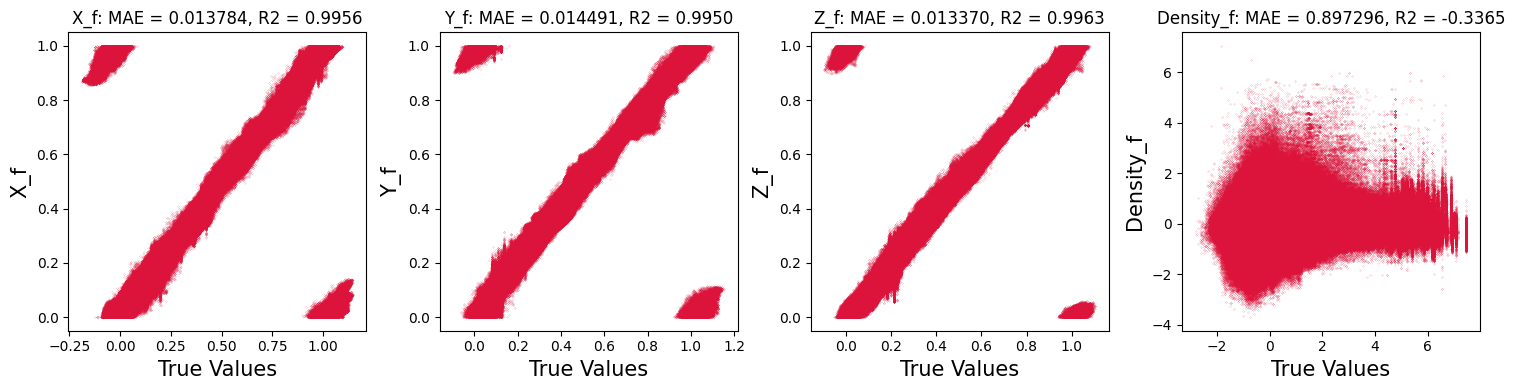

In [40]:
loaded_model = [0,0]
results_dic = {'lvl_1_ypred':[], 'lvl_2_ypred':[], 'ytrue':y_test, 'ztrue':z_test, 'xtest': X_test}
#Step 1 prediction
i=0
loaded_model[i] = xgb.XGBRegressor()
loaded_model[i].load_model("Combined_nb101_u502_lvl1_nnmodel.json")
ypred, ytrue = model_test(loaded_model[i], X_test), y_test
results_dic['lvl_1_ypred'] = ypred
a_test = get_lvl1_dataset(X_test,ypred)
#Step 2 prediction
i=1
loaded_model[i] = xgb.XGBRegressor()
loaded_model[i].load_model("Combined_nb101_u502_lvl2_nnmodel.json")
zpred, ztrue = loaded_model[i].predict(a_test), z_test
results_dic['lvl_2_ypred'] = zpred
mae_lvl1 = mae_modded(ytrue.to_numpy(), ypred.to_numpy())
r2_lvl1 = r2_modded(ytrue.to_numpy(),ypred.to_numpy())
mae_lvl2 = skm.mean_absolute_error(z_test.to_numpy(), zpred)
r2_lvl2 = skm.r2_score(z_test.to_numpy(),zpred)
all_predicted_truth = ytrue.copy()
all_predicted_truth['Density_f'] = z_test.values
all_predicted_pred = ypred.copy()
all_predicted_pred['Density_f'] = zpred
plot_prediction(all_predicted_truth.to_numpy(),all_predicted_pred.to_numpy(), np.append(mae_lvl1,mae_lvl2), np.append(r2_lvl1,r2_lvl2), append = "_Combined_nb101_u502_nnmodel_")



In [41]:
import pickle
with open('/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/u502_framewise_predictions_using_2_sims_w_density.pickle', 'wb') as handle:
    pickle.dump(results_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
